# DebruijnExtend Benchmarking Analysis
This python notebook was used for gathering the results from benchmarking DebruijnExtend, parsing the information, and plotting the overall outcomes. 

In [313]:
import os
import glob
from pathlib import Path
from enum import Enum
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles

import datetime

# Notebook parameters

In [314]:
FIGURE_DIR = Path("/Users/dreyceyalbin/Desktop/DebruijnExtend_figures/")
if not os.path.isdir(FIGURE_DIR): os.mkdir(FIGURE_DIR)

# PARSERS 
below are the parsers for each of the associated tools. The output format per tool changes, so each tool needs a unique parser

In [315]:
def parser_debext(debExt_dir, extension="ss3", non_test=False, truth_csv=None):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    if truth_csv != None: truth_dict = parse_truth(truth_csv)
    for outputfile in glob.glob(debExt_dir+'/*'+extension): #os.listdir(debExt_dir): 
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            for line_index, line in enumerate(resultlines):
                if line[0] == ">":
                    if non_test:
                        identifier = outputfile.name.split(".")[0]
                    else:
                        identifier = line.strip(">").strip("\n") # uses file name.
                    if truth_csv != None:
                        prediction_outcomes[identifier] = truth_dict[identifier]
                    else:
                        prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
    return prediction_outcomes

def parser_psipred(directory, extension="ss3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            for line_index, line in enumerate(resultlines):
                if line[0] == ">":
                    if non_test:
                        identifier = outputfile.name.split(".")[0]
                    else:
                        identifier = line.strip(">").strip("\n") # uses file name.
                    prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
    return prediction_outcomes

def parser_porter5(directory, extension="ss3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            protein = []
            for line_index, line in enumerate(resultlines):
                line = line.split("\t")
                if (line_index > 0):
                    protein.append(line[2])
                    #prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
            identifier = outputfile.name.split(".")[0]
            prediction_outcomes[identifier] = ''.join(protein)
    return prediction_outcomes

def parser_spider(directory, extension="spd3", non_test=False):
    """
    This function parses the debext output directory.
    OUTPUT:
        dict = {}
    """
    prediction_outcomes = {}
    for outputfile in glob.glob(directory+'/*'+extension):
        with open(Path(outputfile)) as resultsfile:
            resultlines = resultsfile.readlines()
            outputfile = Path(outputfile)
            protein = []
            for line_index, line in enumerate(resultlines):
                line = line.split("\t")
                if (line_index > 0):
                    protein.append(line[2])
                    #prediction_outcomes[identifier] = resultlines[line_index+2].strip("\n")
            identifier = outputfile.name.split(".")[0]
            prediction_outcomes[identifier] = ''.join(protein)
    return prediction_outcomes

def get_times(directory):
    """
    grabs time per protein in an output directory
    """
    time_outcomes = {}
    for outputfile in glob.glob(directory+'/*time*'):
        outputfile = Path(outputfile)
        with open(outputfile) as resultsfile:
            resultlines = resultsfile.readlines()
            # PARSE THE TIME OUT HERE
            real = resultlines[-3].split("\t")[1].strip("\n").strip(" ")
            user = resultlines[-2].split("\t")[1].strip("\n").strip(" ")
            system = resultlines[-1].split("\t")[1].strip("\n").strip(" ")
            time_dict = {"real" : real, 
                         "user" : user, 
                         "system" : system}
            for time_type, time in time_dict.items():
                try:
                    hour, hour_left_over = time.split('h')
                    hour = float(hour)
                except:
                    hour_left_over = time
                    hour = 0
                minute, minute_left_over = hour_left_over.replace('h','').split('m')
                second, second_left_over = minute_left_over.replace('m','').split('s')
                time_dict[time_type] = (float(hour), float(minute), float(second))
            identifier = outputfile.name.split(".")[0].replace("_time", "")
            time_outcomes[identifier] = time_dict
    return time_outcomes

# Gathering Results
The functions below are used for each tool.

In [316]:
class ResultStruct:
    """ datastruct for holding results """
    
    def __init__(self):
        self.accuracy : list = []
        self.length : list = []
        self.conf_matrix = np.zeros((3,3))
        self.pdb_names : list = []
        self.time : Dict[str, Dict[str,float]] = {}
        self.pdb2length : Dict[str, float]  = {}

def parse_dir(directory, truth_csv, parser_function):
    """
    This function parses all files within an output
    folder for DebruijnExtend.

    OUTPUT:                                                                     
        results = { "accuracy" : [[.8, .4, ..., 0.7], # percent guessed correctly  
                    "length" : [254, 223, ..., 30], # length per                
                    "conf_matrix" : [[],[],[]] # confusion matrix}
    """
    #results_dict = {test_iteration : [[], [], np.zeros((3,3))] }
    results: ResultStruct = ResultStruct()
    seq_dict = parser_function(directory) ### CHANGE
    truth_dict = parse_truth(truth_csv)
    results.time = get_times(directory)
    for identifier, prediction in seq_dict.items():
        true_ss3 = truth_dict[identifier]
        accuracy, confusion_matrix = prediction_rank(prediction, true_ss3)
        # append results to dictinoary
        results.accuracy.append(accuracy)
        results.length.append(len(true_ss3))
        results.pdb2length[identifier] = len(true_ss3)
        results.conf_matrix += confusion_matrix
        results.pdb_names.append(identifier)
    return results
    
def parse_truth(truth_csv, parsing_index=3):
    """
    parses the truth CSV to get the actual ss3
    """
    truth_dict = {}
    with open(truth_csv) as file_by_lines:
        file_lines = file_by_lines.readlines()
        for index, line in enumerate(file_lines):
            identifier = line.split(",")[parsing_index-2].strip("\n").strip("'")
            truth_dict[identifier] = line.split(",")[parsing_index].strip("\n").strip("'") #TODO: ASSUMES SAME ORDER AS FASTA!!
    return truth_dict

def prediction_rank(prediction, true):                                 
    """                                                                         
    This function scores the accuracy of a prediction.     
                                                                                
    INPUT: 1. an input prediction sequence
           2. the true secondary structure sequence
    OUTPUT: 1. percent guessed correctly (range: 0-1)
            2. confusion matrix
    """
    # init
    confusion_matrix = [[0,0,0],[0,0,0],[0,0,0]]
    map_dict = {"C" : 0, "E" : 1, "H" : 2}
    prediction_array = np.zeros((len(true)))
    # iterate through predicted and true
    for index in range(len(prediction)):
        # update prediction_array
        if prediction[index] == true[index]:
            prediction_array[index] = 1
        # update confusion matrix
        if (true[index] in map_dict.keys()) and (prediction[index] in map_dict.keys()):
            true_ind = map_dict[true[index]]
            pred_ind = map_dict[prediction[index]]
            confusion_matrix[true_ind][pred_ind] += 1
    # calculate the accuracy
    accuracy = round(sum(prediction_array) / len(prediction_array), 4)

    return accuracy, confusion_matrix 

In [317]:
def plot_confusion_matrix(input_results: ResultStruct, 
                          fig_path=None, 
                          title: str=None):                                                        
    """                                                                         
    This function plot the confusion matrix 
    """ 
    total_confusion = input_results.conf_matrix
    for row_ind, row in enumerate(total_confusion):
        total_confusion[row_ind] /= np.sum(total_confusion[row_ind])
    print(total_confusion)
    # turn array into pandas dataframe
    total_confusion = pd.DataFrame(total_confusion, 
                                   columns=['C', 'E', 'H'], 
                                   index=['C', 'E', 'H'])
    ## plot confusion matrix
    ax = sns.heatmap(total_confusion, annot=True, linewidths=.5, cmap='binary')
    if title: plt.title(title)
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

def avg_acc_per_length(input_results: ResultStruct, 
                       fig_path=None, 
                       title: str=None):
    """
    This plots a scatter plot for a particular software. The scatterplot 
    shows accuracy vs length
    """
    thresh=0.9
    total_accuracy_array = input_results.accuracy
    total_length_array = input_results.length
    # plot
    plt.axhline(y=thresh, color='black', linestyle='--')
    plt.scatter(total_length_array, total_accuracy_array, color="black", vmax=1.1)#, edgecolor="b")
    plt.ylabel("Accuracy")
    plt.xlabel("Protein Length")
    if title: plt.title(title)
    plt.ylim(.2, 1.1)
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

def difference_vendiagram(input_results_dict, 
                          fig_path=None, 
                          threshold=0.9, 
                          colors=['blue', 'orange', 'green', 'red'], 
                          font=14):
    """
    This function plots a vendiagram of the tools for all of the predictions.
    """
    results = []
    for software_name, software_i in multi_input_results.items():
        accuracy_array = list(multi_input_results[software_name].accuracy)
        correct_set = []
        for index, result in enumerate(accuracy_array):
            if (result < threshold):
                correct_set.append(str(index))
        results.append(set(correct_set))
    out = venn3(results, (software for software in input_results_dict.keys()), set_colors=colors, alpha = 1)
    venn3_circles(subsets=results, linestyle='dashed', linewidth=2, color='black');
    for text in out.set_labels:
        text.set_fontsize(font)
    for text in out.subset_labels:
        if text != None:
            text.set_fontsize(font)
    #plt.title(f"Shared proteins with less than {threshold}% accuracy \n\n")
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

def plot_bar(multi_input_results, 
             fig_path=None, 
             title='Secondary Structure Prediction Accuracy', 
             colors=None, 
             xaxis=None, 
             axis_size=15, 
             title_size=20):
    """
    This method plots a simple bar graph for the data.
    input: list of dicts per software.
    """
    N = 1
    fig, ax = plt.subplots()
    # create array with means and STDs
    meadSTD = []
    for software_name, software_i in multi_input_results.items():
        accuracy_array = list(multi_input_results[software_name].accuracy)
        print(f"{software_name}, {np.average(accuracy_array)}")
        meadSTD.append(accuracy_array)
    meadSTD = np.array(meadSTD, dtype=object).transpose()
    meadSTD_df = pd.DataFrame(meadSTD) #, columns=multi_input_results.keys(), index=['mean', 'STD'])
    ax = sns.violinplot(data=meadSTD_df, scale="width", palette=colors)
    ax.set_title(title, size= title_size)
    ax.set_ylabel('Q3 Accuracy', size=axis_size)
    ax.set_xticklabels(multi_input_results.keys(), rotation='vertical', size=axis_size)
    if xaxis: ax.set_xlabel(xaxis, size=axis_size)
    plt.ylim(0, 1.3)
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_timing(multi_input_results,
                fig_path=None,
                time_type='user', 
                title='Speed Benchmark (Amino Acids per second [log10])', 
                colors=["#79addc", "#fcac5d", "#89d2a3", "#f25757"], 
                axis_size=10, 
                title_size=15):
    """
    This method plots the time needed to run each of the 
    tools given an input 'class ResultStruct'.
    
    Time dict expect in (Results.time):
        {'real': (0.0, 20.0, 47.676), 
         'user': (0.0, 92.0, 32.942), 
         'system': (0.0, 11.0, 9.217)}
    """
    N = 1
    fig, ax = plt.subplots()
    # create array with means and STDs
    meadSTD = []
    for software_name, software_i in multi_input_results.items():
        time_array = []
        for pdb_name, result in software_i.time.items():
            time = result[time_type]
            total_time = time[0]*60*60+time[1]*60+time[2]
            protein_length = software_i.pdb2length[pdb_name]
            aminoacids_per_second = np.log10(protein_length / total_time)
            time_array.append(aminoacids_per_second)
        meadSTD.append(time_array)
        print(f"{software_name},{10**(np.average(time_array))}")
    meadSTD = np.array(meadSTD, dtype=object).transpose()
    meadSTD_df = pd.DataFrame(meadSTD) #, columns=multi_input_results.keys(), index=['mean', 'STD'])
    ax = sns.boxplot(data=meadSTD_df, palette=colors)
    sns.despine(offset=10, trim=True)
    ax.set_title(title, size=title_size)
    ax.set_ylabel('Amino acids per Second (log10)', size=axis_size)
    ax.set_xticklabels(multi_input_results.keys(), rotation='vertical', size=axis_size)
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_lengthVsTime(input_results: ResultStruct, 
                      time_type='user', 
                      title='time vs protein length'):
    """
    plots the sequences time over the length (scatter plot)
    """
    time_results = []
    length = []
    for pdb_struct, time in input_results.time.items():
        length.append(input_results.pdb2length[pdb_struct])
        time = time[time_type]
        time = np.log(time[0]*60*60+time[1]*60+time[2]) 
        time_results.append(time)

    # plot
    plt.scatter(length, time_results, color="black")#, edgecolor="b")
    plt.ylabel("Time (log seconds)")
    plt.xlabel("Protein Length")
    plt.title(title)

    plt.show()
    
    
def get_count_dict(tool_results):
    """
    finds the lengths for each structure type
    """
    count_dict = {'C' : [], 'E': [], 'H' : []}
    for seq_number, prediction in enumerate(tool_results.values()):
        last_ss3 = None
        length = 0 
        for ss3 in prediction:
            if last_ss3 != None:
                if ss3 == "'": ss3 = 'C'
                if (ss3 == last_ss3):
                    length += 1
                else:
                    if ss3 == "'": print(f"{col}")
                    count_dict[ss3].append(length)
                    length = 1
                    last_ss3 = ss3
            else:
                last_ss3 = ss3
                length += 1

    return count_dict

def plot_structureLengths(tool_results, 
                          max_height=500, 
                          title='Lengths of Protein Substructures'):
    """
    plots the histogram of lengths observed.
    """
    fullname_dict = {'C' : 'Random Coil', 'E': 'Beta Sheet', 'H' : 'Alpha Helix'}
    count_dict = get_count_dict(tool_results)
    fig, axs = plt.subplots(len(count_dict.keys()), figsize=(5,5))
    fig.suptitle(title)
    fig.tight_layout(w_pad=2.0, h_pad=2.0)
    #plt.ylim(0,max_height)
    for index, ss3 in enumerate(count_dict.keys()):
        avg = round(np.average(count_dict[ss3]),2)
        std = round(np.std(count_dict[ss3]),2)
        print(f"{ss3}, {avg}, {std}")
        axs[index].set_ylim(0, max_height)
        axs[index].hist(count_dict[f'{ss3}'], 
                            bins=30, 
                            range=(0,60), 
                            color='#D3D3D3',
                            edgecolor='black')
        offset=50
        axs[index].text(offset,
                        max_height-(0.25*max_height), 
                        f"Average = {avg} \n STD = {std}", 
                        size=10, 
                        rotation=0,
                        ha="center", 
                        va="center",
                        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
                        )
        axs[index].set_title(f'Length Distributon for {fullname_dict[ss3]}')
    plt.show()
    
    
def bhattacharyya_distance(truth, r2, avg_col=0, std_col=1):
    """
    Uses an input dictionary to calculate the *inverse* Bhattacharyya distance
    """
    inner_term = (truth[std_col]**2 / r2[std_col]**2) + (r2[std_col]**2 / truth[std_col]**2) + 2
    dist = (1/4) * np.log( (1/4) * inner_term)
    dist += (1/4) * ( (truth[avg_col] - r2[avg_col])**2 / (truth[std_col]**2 + r2[std_col]**2) )
    return 1/dist

def plot_structureLengthsDistances(tool_results: Dict[str, Dict[str,str]],
                                   fig_path=None,
                                   truth_key='truth',
                                   max_height=500, 
                                   title='Inverse Bhattacharyya Distance from Truth \n Length Distributions',
                                   colors=['white', 'grey', 'black'],
                                   axis_size=10, 
                                   title_size=15):
    """
    plots the histogram of lengths observed.
    """
    fullname_dict = {'C' : 'Random Coil ("C")', 'E': 'Beta Sheet ("E")', 'H' : 'Alpha Helix ("H")'}
    # get avg, std per ss3 per tool
    results_dict = {}
    for tool, results in tool_results.items():
        count_dict = get_count_dict(results)
        results_dict[tool] = {}
        for index, ss3 in enumerate(count_dict.keys()):
            avg = round(np.average(count_dict[ss3]),2)
            std = round(np.std(count_dict[ss3]),2)
            results_dict[tool][ss3] = [avg, std]
    # calculate distance matrix
    tools_array = []
    results_stdavg = {}
    for tool, results in results_dict.items():
        if tool != truth_key:
            tools_array.append(tool)
            for ss3, avg_std in results.items():
                true_avg = results_dict[truth_key][ss3]
                dist = bhattacharyya_distance(true_avg, avg_std)
                if ss3 in results_stdavg:
                    results_stdavg[ss3].append(dist)
                else: 
                    results_stdavg[ss3] = [dist]
                print(f"{tool} {ss3} {dist}")
    # plot
    X = np.arange(len(tools_array))
    dist_increment = 1 / len(tools_array)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    dist_count = 0
    plt.title(title,size=title_size)
    plt.ylabel("Inverse Bhattacharyya distance", size=axis_size)
    plt.xlabel("Tool", size=axis_size)
    ax.set_xticks(X)
    ax.set_xticklabels(tools_array, rotation=65, size=axis_size)
    count=0
    for ss3, results_array in results_stdavg.items():
        ax.bar(X + dist_count, results_array, color = colors[count], width = dist_increment, edgecolor='black')
        dist_count += dist_increment
        count += 1
    ax.legend(labels=[fullname_dict[ss3] for ss3 in results_stdavg.keys()])
    
    if fig_path:
        plt.savefig(fig_path, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    

# Benchmarking

This script parses the output from all of the tools and gathers acccuracies per protein.

[0.9839, 0.8373, 0.7945, 0.7826, 0.8774, 0.2971, 0.9495, 0.9725, 0.8673, 0.7159, 0.9535, 1.0, 0.9748, 0.9342, 0.9686, 0.9851, 0.802, 0.9452, 0.9623, 0.4286, 0.9519, 0.9751, 0.9924, 0.9756, 0.997, 0.9809, 0.9521, 0.9959, 0.9286, 0.9968, 0.9799, 0.9949, 0.9666, 0.8916, 0.9147, 0.9372, 0.9522, 0.4221, 0.7839, 0.9269, 0.9685, 0.8604, 1.0, 0.9631, 0.975, 0.8983, 0.9875, 0.8986, 0.9343, 0.9962, 0.9922, 0.9889, 0.25, 0.9853, 0.9952, 0.9733, 1.0, 0.9806, 0.9804, 0.8571, 0.9848, 0.9728, 0.9307, 0.9922, 0.8165, 0.8608, 0.9559, 0.9276, 0.9186, 0.9658, 0.9158, 0.1287, 0.9952, 0.7913, 0.7333, 0.8413, 0.9487, 0.9959, 0.8973, 0.8471, 0.9749, 0.9844, 0.7031, 0.9421, 0.9046, 0.3972, 0.7006, 0.8217, 0.7073, 0.9766, 0.9631, 0.9602, 0.9714, 0.8986, 0.9924, 0.9608, 0.4409, 0.9579, 1.0, 0.9801, 0.8696, 0.958, 0.9872, 0.7267, 0.9818, 0.8293, 0.978, 0.9512, 0.3577, 0.9808, 0.9747, 1.0, 0.9158, 0.9866, 0.674, 0.9071, 0.9955, 0.3667]
DebruijnExtend, 0.8824779661016949


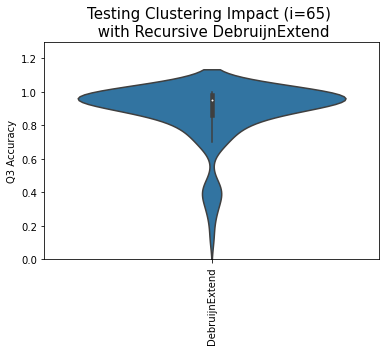

In [318]:
prev_path = "../../benchmarking/tools/"

########
# obtan results dictionaries.
########
multi_input_results = {}
TOOL_COLORS = ["#79addc", "#fcac5d", "#89d2a3", "#f25757"]
bench_suffix = "FinalizedBenchmarking_k6"
debExt_dir_3 = prev_path+"debext_"+bench_suffix
debExt_dir = parse_dir(debExt_dir_3, prev_path+"TESTING_FINALTESTS.csv", parser_function=parser_debext)
multi_input_results[f"DebruijnExtend"] = debExt_dir

print(debExt_dir.accuracy)
# Create figure per run
plot_bar(multi_input_results, 
             title_size=15,
             axis_size=10,
             title=f"Testing Clustering Impact (i={identity_cut}) \n with Recursive DebruijnExtend")

[0.4638, 0.6105, 0.7333, 0.5, 0.7266, 0.4958, 0.519, 0.4167, 0.5676, 0.3128, 0.6058, 0.524, 0.522, 0.5548, 0.5471, 0.472, 0.5402, 0.5363, 0.637, 0.6846]
[0.9275, 0.657, 0.4667, 0.6686, 0.9784, 0.8782, 0.5333, 0.3854, 0.5068, 0.959, 0.8173, 0.8462, 0.8242, 0.8725, 0.9574, 0.9037, 0.8448, 0.943, 0.5963, 0.9885]
DebruijnExtend 
 (k=3), 0.5484950000000001
DebruijnExtend 
 (k=6), 0.7777399999999999


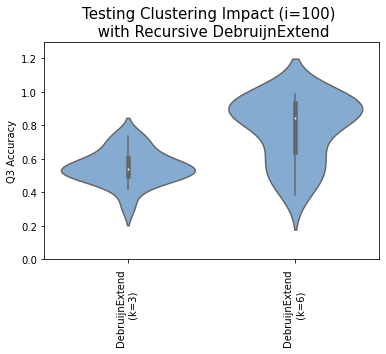

[0.4879, 0.6915, 0.7055, 0.6425, 0.6098, 0.6418, 0.625, 0.6729, 0.3963, 0.5986, 0.3725, 0.4765, 0.3667, 0.5294, 0.5054, 0.6093, 0.6142, 0.4945, 0.6768, 0.5433]
[0.5545, 0.4726, 0.6986, 0.9435, 0.3415, 0.8745, 0.5536, 0.6449, 0.5152, 0.528, 0.451, 0.4608, 0.275, 0.5241, 0.5924, 0.5528, 0.731, 0.6036, 0.5976, 0.4867]
DebruijnExtend 
 (k=3), 0.5630200000000001
DebruijnExtend 
 (k=6), 0.570095


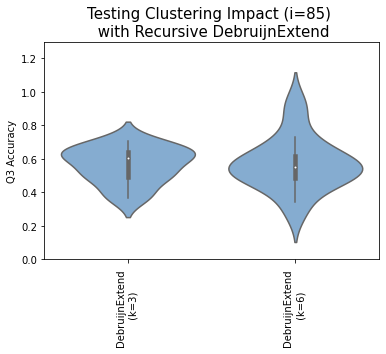

[0.5369, 0.4363, 0.7983, 0.5547, 0.5924, 0.4859, 0.7554, 0.5802, 0.3516, 0.619, 0.6007, 0.2021, 0.5846, 0.5452, 0.6091, 0.5874, 0.5938, 0.6643, 0.5227, 0.6349]
[0.4631, 0.5245, 0.4286, 0.4534, 0.4927, 0.5915, 0.4076, 0.5401, 0.8203, 0.6054, 0.4785, 0.4043, 0.4962, 0.5251, 0.6242, 0.4854, 0.5347, 0.4895, 0.4091, 0.4544]
DebruijnExtend 
 (k=3), 0.562775
DebruijnExtend 
 (k=6), 0.51143


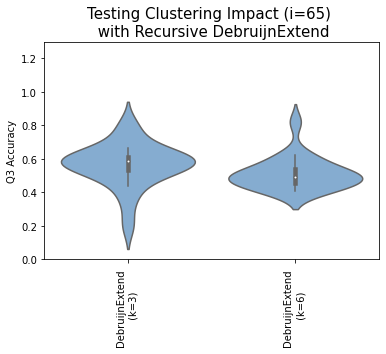

In [319]:
prev_path = "../../benchmarking/tools/"

########
# obtan results dictionaries.
########

TOOL_COLORS = ["#79addc", "#fcac5d", "#89d2a3", "#f25757"]
identities_tested = [100, 85, 65]
for identity_index, identity_cut in enumerate(identities_tested):
    multi_input_results = {}
    for k_val in [3,6]:
        bench_suffix = f"testing{identity_cut}_k{k_val}_r"
        debExt_dir_3 = prev_path+"debext_"+bench_suffix
        debExt_dir = parse_dir(debExt_dir_3, prev_path+f"TESTING_{identity_cut}.csv", parser_function=parser_debext)
        multi_input_results[f"DebruijnExtend \n (k={k_val})"] = debExt_dir
        print(debExt_dir.accuracy)
    # Create figure per run
    plot_bar(multi_input_results, 
             colors=["#79addc","#79addc"], 
             title_size=15,
             axis_size=10,
             title=f"Testing Clustering Impact (i={identity_cut}) \n with Recursive DebruijnExtend")

5
DebruijnExtend (k=6), 0.8824779661016949
DebruijnExtend (k=10), 0.8836313559322035
Porter5, 0.8396898305084747
Spider2, 0.7569830508474575
S4PRED, 0.7420635593220338


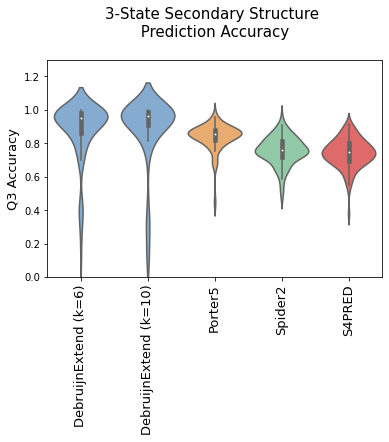

DebruijnExtend (k=6),19.67393558887458
DebruijnExtend (k=10),13.481865503329871
Porter5,0.6333850097301199
Spider2,0.02467701558801696
S4PRED,41.46064327703688


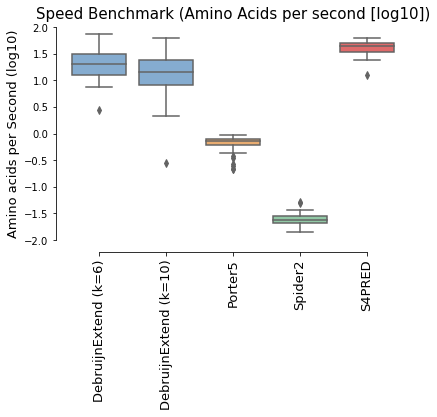

[[0.90013612 0.05865611 0.04120777]
 [0.03085399 0.96391185 0.00523416]
 [0.04496538 0.05656127 0.89847335]]


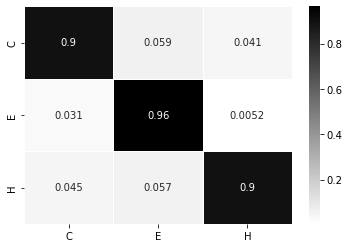

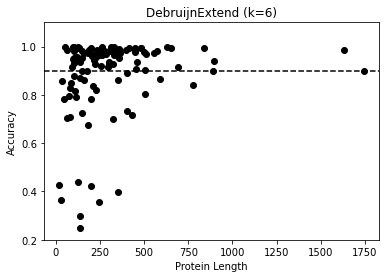

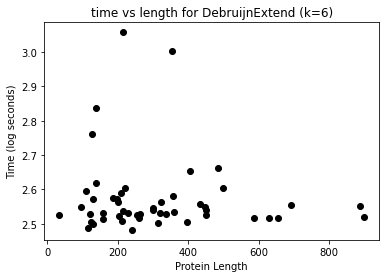

[[0.91009776 0.05859423 0.03130801]
 [0.02892562 0.96928375 0.00179063]
 [0.03053308 0.05514307 0.91432385]]


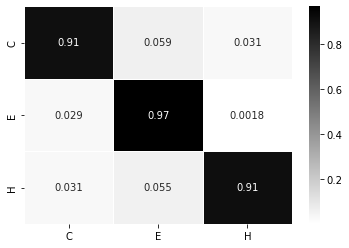

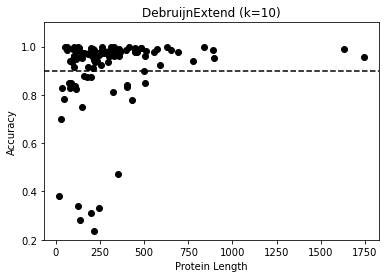

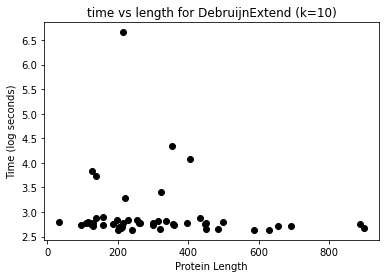

[[0.83236386 0.05550743 0.11212871]
 [0.21570248 0.76625344 0.01804408]
 [0.11871194 0.00767498 0.87361308]]


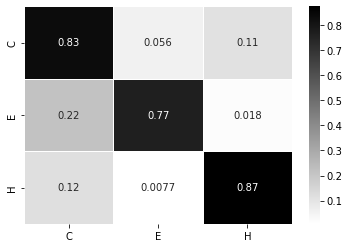

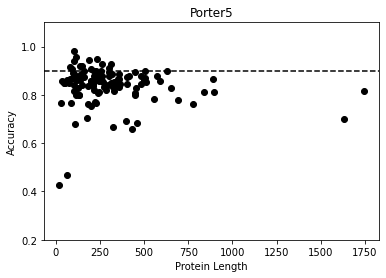

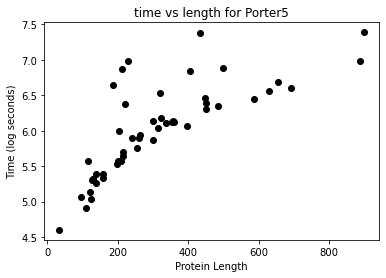

[[0.7776884  0.08854102 0.13377057]
 [0.28856749 0.63402204 0.07741047]
 [0.16417786 0.03562192 0.80020022]]


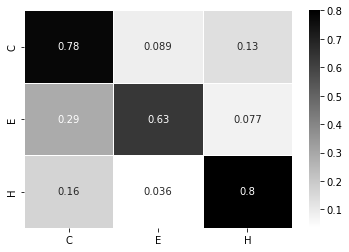

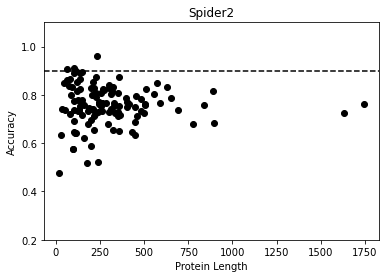

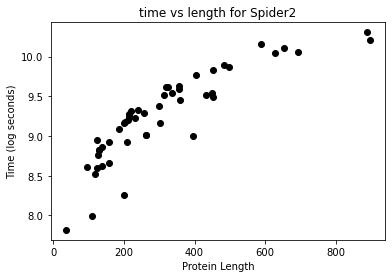

[[0.77874025 0.07567133 0.14558842]
 [0.35440771 0.57493113 0.07066116]
 [0.18620172 0.02869776 0.78510053]]


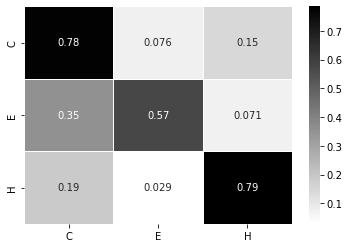

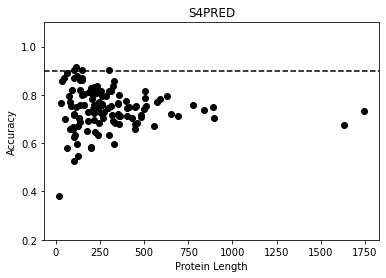

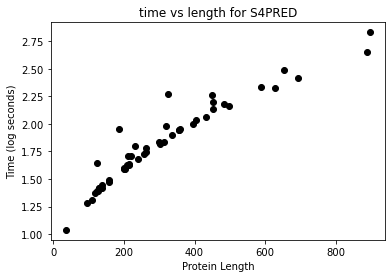

KeyError: '\n DebruijnExtend \n (k=6)'

In [320]:
# PATHS
prev_path = "../../benchmarking/tools/"
bench_suffix = "FinalizedBenchmarking/"
debExt_dir_k6 = prev_path+"debext_"+'FinalizedBenchmarking_k6/'
debExt_dir_k10 = prev_path+"debext_"+'FinalizedBenchmarking_k10/'
psipred_dir = prev_path+"s4pred_"+bench_suffix
porter5_dir = prev_path+"porter5_"+bench_suffix
spider_dir = prev_path+"spider2_"+bench_suffix
truth_csv = prev_path+"TESTING_FINALTESTS.csv"

########
# obtan results dictionaries.
########
debExt_dir_k6 = parse_dir(debExt_dir_k6, truth_csv, parser_function=parser_debext)
debExt_dir_k10 = parse_dir(debExt_dir_k10, truth_csv, parser_function=parser_debext)
psipred_result = parse_dir(psipred_dir, truth_csv, parser_function=parser_psipred)
porter5_result = parse_dir(porter5_dir, truth_csv, parser_function=parser_porter5)
spider_result = parse_dir(spider_dir, truth_csv, parser_function=parser_spider)


print(len(debExt_dir_3r.accuracy))
########
# obtain plots.
########

# Create results dictionary
multi_input_results = {"DebruijnExtend (k=6)" : debExt_dir_k6, 
                       "DebruijnExtend (k=10)" : debExt_dir_k10, 
                       "Porter5" : porter5_result,
                       "Spider2" : spider_result,
                       "S4PRED" : psipred_result,
                      }
# for results in multi_input_results.values():
#     print(sorted(results.accuracy))
#     print(np.average(results.accuracy))

# plot the violin plots for all of the results
plot_bar(multi_input_results, 
         fig_path=FIGURE_DIR / Path("accuracy"),
         colors=["#79addc", "#79addc", "#fcac5d", "#89d2a3", "#f25757"], 
         title="3-State Secondary Structure \n Prediction Accuracy \n",
         axis_size=13, 
         title_size=15)
plot_timing(multi_input_results, 
            fig_path=FIGURE_DIR / Path("timing"),
            colors=["#79addc", "#79addc", "#fcac5d", "#89d2a3", "#f25757"], 
            axis_size=13)

# plot various metrics per plot
for key, value in multi_input_results.items():
    plot_confusion_matrix(value, key)
    avg_acc_per_length(value, key, title=f"{key}")
    plot_lengthVsTime(value, title=f"time vs length for {key}")
    
# plot shared error proteins between top 3 tools
del multi_input_results["S4PRED"]
del multi_input_results["\n DebruijnExtend \n (k=6)"]
difference_vendiagram(multi_input_results, 
                      #fig_path=FIGURE_DIR / Path("shared_proteins_80"),
                      threshold=0.80, 
                      font=18, 
                      colors=["#79addc", "#fcac5d", "#89d2a3", "#f25757"])
difference_vendiagram(multi_input_results, 
                      #fig_path=FIGURE_DIR / Path("shared_proteins_70"),
                      threshold=0.70, 
                      font=18, 
                      colors=["#79addc", "#fcac5d", "#89d2a3", "#f25757"])

In [ ]:
# PATHS
prev_path = "../../benchmarking/tools/"
bench_suffix = "FinalizedBenchmarking/"
true_dir = prev_path+"debext_"+bench_suffix
debExt_dir_k6 = prev_path+"debext_"+'FinalizedBenchmarking_k6/'
debExt_dir_k10 = prev_path+"debext_"+'FinalizedBenchmarking_k10/'
psipred_dir = prev_path+"s4pred_"+bench_suffix
porter5_dir = prev_path+"porter5_"+bench_suffix
spider_dir = prev_path+"spider2_"+bench_suffix
# truth csv
truth_csv = prev_path+"TESTING_FINALTESTS.csv"
# parsing
true = parser_debext(true_dir , non_test=True, truth_csv=truth_csv)
debExt_dir_k6 = parser_debext(debExt_dir_k6, non_test=True)
debExt_dir_k10 = parser_debext(debExt_dir_k10, non_test=True)
phage_porter5 = parser_porter5(porter5_dir, non_test=True)
phage_spider = parser_spider(spider_dir, non_test=True)
phage_psipred = parser_psipred(psipred_dir, non_test=True)

############
# Similiariity matrix between tools
############

plot_structureLengths(debExt_dir_k10, max_height=800, title="DebruijnExtend (k=10) Length Distributons")

tool_results = {'truth' : true,
                "\n DebruijnExtend \n (k=6)" : debExt_dir_k6, 
                "\n DebruijnExtend \n (k=10)" : debExt_dir_k10, 
                'Porter5' : phage_porter5,
                'Spider2' : phage_spider,
                'S4Pred' : phage_psipred
                }
plot_structureLengthsDistances(tool_results,
                               fig_path=FIGURE_DIR / Path("length_distances"),
                               axis_size=15)

In [ ]:
threshold = 0.60
for index, accuracy in enumerate(debExt_dir_3r.accuracy):
    if accuracy < threshold:
        print(f"{accuracy} less than {threshold}")
        print(debExt_dir_3r.pdb_names[index])

[0.4853, 0.6889, 0.6238, 0.5291, 0.5906]
[0.5941, 0.7492, 0.6584, 0.6633, 0.6199]
[0.9, 0.8266, 0.8465, 0.8878, 0.8158]
[0.9647, 0.935, 0.995, 0.976, 1.0]
[0.9735, 0.743, 1.0, 0.98, 1.0]
[0.9824, 0.7477, 1.0, 0.984, 1.0]
[0.9853, 0.7477, 1.0, 0.986, 0.9971]
[0.9853, 0.7492, 1.0, 0.984, 1.0]
[1.0, 0.9752, 1.0, 0.992, 1.0]
[1.0, 0.9876, 1.0, 1.0, 1.0]
[1.0, 0.9752, 1.0, 0.992, 1.0]
[1.0, 0.9876, 1.0, 1.0, 1.0]
k=3, 0.58354
k=4, 0.65698
k=5, 0.85534
k=6, 0.97414
k=7, 0.9393
k=8, 0.94282
k=9, 0.94322
k=10, 0.9437
k=15, 0.99344
k=20, 0.9975200000000001
k=25, 0.99344
k=30, 0.9975200000000001


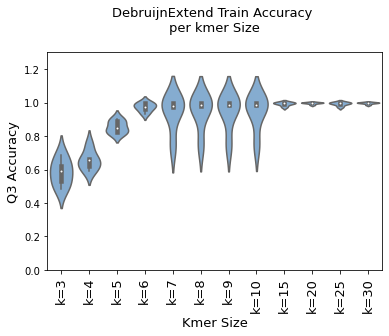

In [321]:
# PATHS
prev_path = "../../benchmarking/tools/"
debExt_dir_3 = prev_path+"debext_output_k3"
debExt_dir_4 = prev_path+"debext_output_k4"
debExt_dir_5 = prev_path+"debext_output_k5"
debExt_dir_6 = prev_path+"debext_output_k6"
debExt_dir_7 = prev_path+"debext_output_k7"
debExt_dir_8 = prev_path+"debext_output_k8"
debExt_dir_9 = prev_path+"debext_output_k9"
debExt_dir_10 = prev_path+"debext_output_k10"
debExt_dir_15 = prev_path+"debext_output_k15"
debExt_dir_20 = prev_path+"debext_output_k20"
debExt_dir_25 = prev_path+"debext_output_k25"
debExt_dir_30 = prev_path+"debext_output_k30"
truth_csv = prev_path+"TESTING.csv"

########
# obtan results dictionaries.
########
debExt_dir_3r = parse_dir(debExt_dir_3, truth_csv, parser_debext)
debExt_dir_4r = parse_dir(debExt_dir_4, truth_csv, parser_debext)
debExt_dir_5r = parse_dir(debExt_dir_5, truth_csv, parser_debext)
debExt_dir_6r = parse_dir(debExt_dir_6, truth_csv, parser_debext)
debExt_dir_7r = parse_dir(debExt_dir_7, truth_csv, parser_debext)
debExt_dir_8r = parse_dir(debExt_dir_8, truth_csv, parser_debext)
debExt_dir_9r = parse_dir(debExt_dir_9, truth_csv, parser_debext)
debExt_dir_10r = parse_dir(debExt_dir_10, truth_csv, parser_debext)
debExt_dir_15r = parse_dir(debExt_dir_15, truth_csv, parser_debext)
debExt_dir_20r = parse_dir(debExt_dir_20, truth_csv, parser_debext)
debExt_dir_25r = parse_dir(debExt_dir_25, truth_csv, parser_debext)
debExt_dir_30r = parse_dir(debExt_dir_30, truth_csv, parser_debext)

########
# obtain plots.
########
multi_input_results = {"k=3" : debExt_dir_3r,
                       "k=4" : debExt_dir_4r,
                       "k=5" : debExt_dir_5r,
                       "k=6" : debExt_dir_6r,
                       "k=7" : debExt_dir_7r, 
                       "k=8" : debExt_dir_8r,
                       "k=9" : debExt_dir_9r,
                       "k=10" : debExt_dir_10r,
                       "k=15" : debExt_dir_15r,
                       "k=20" : debExt_dir_20r,
                       "k=25" : debExt_dir_25r,
                       "k=30" : debExt_dir_30r}

# print accuracy
for results in multi_input_results.values():
    print(results.accuracy)
    
# make violin plots
plot_bar(multi_input_results, 
         fig_path=FIGURE_DIR / Path("train_accuracy"),
         title="DebruijnExtend Train Accuracy \n per kmer Size \n", 
         colors=["#79addc"],
         xaxis="Kmer Size",
         axis_size=13, 
         title_size=13)

In [ ]:
# PATHS
prev_path = "../../benchmarking/tools/"
truth_csv = prev_path+"TESTING_FINALTESTS.csv"

########
# obtan results dictionaries.
########
multi_input_results = {}
file_name="difficult_sequences_top1"
for kmer_size in [6]:
    offset = 5 if kmer_size==10 else 4
    max_diff = 1 if kmer_size==10 else 2
    # hamming distance
#     dir_suffix = f"{file_name}_{kmer_size}__hammingDistance"
#     debExt_dir = prev_path+f"debext_"+dir_suffix
#     parameter_name = f"DebExt \n (k={kmer_size}, all vs all)"
#     multi_input_results[parameter_name] = parse_dir(debExt_dir, truth_csv, parser_function=parser_debext)
    # clustering
    for cluster_cutoff in range(kmer_size-offset,kmer_size-max_diff):
        dir_suffix = f"{file_name}_{kmer_size}_cluster_k{kmer_size}_CT{cluster_cutoff}"
        debExt_dir = prev_path+f"debext_"+dir_suffix
        parameter_name = f"DebExt \n (k={kmer_size}, CT={cluster_cutoff})"
        print(debExt_dir)
        multi_input_results[parameter_name] = parse_dir(debExt_dir, truth_csv, parser_function=parser_debext)
    
        
########
# obtain plots.
########
print(multi_input_results)
# plot the violin plots for all of the results
plot_bar(multi_input_results, title="Impact of Clustering Threshold (CDHIT i=65) (KNN k=1)")
plot_timing(multi_input_results)
# plot various metrics per plot
for key, value in multi_input_results.items():
    plot_confusion_matrix(value, key)
    avg_acc_per_length(value, key)
    print(np.average(value.accuracy))

In [ ]:
threshold = 0.60
for index, accuracy in enumerate(debExt_dir_3r.accuracy):
    if accuracy < threshold:
        print(f"{accuracy} less than {threshold}")
        print(debExt_dir_3r.pdb_names[index])

In [276]:
prev_path = "../../benchmarking/tools/"
p_debext = prev_path+"debext_spike_proteins3"
p_p4pred = prev_path+"s4pred_spike_proteins"
p_porter5 = prev_path+"porter5_spike_proteins"
p_spider = prev_path+"spider2_spike_proteins"


############
# Parsing output
############
phage_debExt = parser_debext(p_debext, non_test=True)
phage_psipred = parser_psipred(p_p4pred, non_test=True)
phage_porter5 = parser_porter5(p_porter5, non_test=True)
phage_spider = parser_spider(p_spider, non_test=True)

############
# Similiariity matrix between tools
############
tool_predictions = [phage_psipred, phage_porter5, phage_spider, phage_debExt]

similiarity_matrix = np.zeros((len(tool_predictions), 
                               len(tool_predictions)))
for row, tool_1 in enumerate(tool_predictions):
    for col, tool_2 in enumerate(tool_predictions):
        # look through predictions
        for sequence_name, prediction_1 in tool_1.items():
            prediction_2 = tool_2[sequence_name]
            accuracy = prediction_rank(prediction_1, prediction_2)[0]
            accuracy = 90
            similiarity_matrix[row][col] += accuracy
        similiarity_matrix[row][col] /= len(tool_1.items())
        
print(similiarity_matrix)
# print(phage_porter5[0])


[[90. 90. 90. 90.]
 [90. 90. 90. 90.]
 [90. 90. 90. 90.]
 [90. 90. 90. 90.]]


In [72]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
C, 9.389380530973451, 8.916955737035938, phage_debExt
C, 4.947368421052632, 3.599449955972078, phage_spider
C, 6.158357771260997, 9.095686948040289, PORTER5
C, 5.768976897689769, 3.5903374097204153, phage_psipred

NameError: name 'C' is not defined

In [ ]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
H, 30.977272727272727, 36.93082516147504, DebriujnExtend
H, 4.86231884057971, 4.739889359965852, SPIDER
H, 6.934426229508197, 8.164033181310664, PORTER5
H, 11.484848484848484, 22.005675868547836, P4PRED

In [ ]:
[phage_psipred, phage_porter5, phage_spider, phage_debExt]
E, 28.044776119402986, 25.138679738198828, DebriujnExtend
E, 4.663608562691132, 3.9465065811931304, SPIDER
E, 6.336805555555555, 5.416772390349997, PORTER5
E, 7.2, 6.200822209871153, P4PRED